# Performance Data Comparison

This document details a summary of performance benchmark data collected over multiple benchmark tests on the Gorouter.

To understand the current performance of Gorouter, follow the blue lines and data points in the plots below. The red lines and data points are offered as a comparison with an older version of Gorouter.

(Click the button below to toggle the display of the code used to generate these graphs.)

In [33]:
from IPython.display import HTML
HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

In [34]:
# To only view one set of data, set the below variable to False and rerun all of the cells.
compareDatasets = True

In [35]:
# SETUP: All of the imports
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

matplotlib.rcParams['figure.figsize'] = 9, 6
matplotlib.rcParams['legend.loc'] = 'best'

# We'll need these packages for plotting fit lines
import statsmodels.api as sm
from patsy import dmatrices

from io import StringIO
import re

from IPython.display import Markdown

import os.path
assert os.path.isfile('cpuStats.csv'), 'Missing CPU stats file "cpuStats.csv"'
assert os.path.isfile('perfResults.csv'), 'Missing performance results file "perfResults.csv"'


if compareDatasets:
    assert os.path.isfile('old_cpuStats.csv'), 'Missing old CPU stats file "old_cpuStats.csv"'
    assert os.path.isfile('old_perfResults.csv'), 'Missing old performance results file "old_perfResults.csv"'
    newDataLabel = 'after'
    oldDataLabel = 'before'

## Setup

### Testing Environment

We elected to do our testing on AWS (Amazon Web Services) for its stability.

Here is the configuration of the VMs that we deployed on AWS:

 - `http_route_populator` (m3.medium)
 - `nats` (m3.medium)
 - `gorouter` (c3.large)
 - `gostatic` (backend app, c3.large)
 - `throughputramp` (benchmarking client, c3.large)
 
The `http_route_populator` is responsible for populating `gorouter`'s routing table with routes via the `NATS` messaging bus. This job will perioidically reregister 100,000 routes in `gorouter`.

`gostatic` is the backend app behind every route registered in `gorouter`. Making a request with any of these routes will cause `gorouter` to proxy the request to `gostatic`. Requests made to `gostatic` will return a `200 OK` HTTP response with 1024 bytes of data.

`gorouter` is the component under test. It is deployed alongside a job that will monitor CPU load for the duration of the test.

`throughputramp` is responsible for generating load by making requests to routes via `gorouter`. As the name implies, it will linearly ramp concurrent load on the Gorouter and record the time and latency of every response to the load.

## Gorouter CPU Load over Time

The following plot shows a summary of the CPU load over the duration of the test run, labeled in seconds since the benchmark test started.

Here are some key points to note when looking at this data:

  - Each CPU sample collected is highly variable since this is the characteristic of the CPU load on Gorouter when
    it is handling requests. This data has been downsampled into larger windows in order to smooth out variations that
    happen over a short period of time. The mean of each window is represented in the plot to depict the average CPU load
    over time.
  - There are tall spikes that show up periodically about every 60 seconds. This corresponds to the periodic registration of
    100,000 routes from the `http_route_populator`.
  - It's possible for the line to cut off before the end of the plot. This indicates that the performance test run
    finished at the cut off point.
  - There may be many jagged small spikes throughout the plot. This corresponds to the starting and stopping of the tests
    for each load level during the throughput rampup.
  - The CPU graph plateaus, but doesn't quite reach 100% CPU utilization. Since the mean CPU load is
    represented in the plot, some points in the plateau may represent both high (100%) and low (80%) points in the actual data.

In [36]:
# To only view one set of data, set the below variable to False and rerun all of the cells.
resampleFrequency = 5

In [37]:
def processCpuData(data):
    meanData = data.resample('{0}s'.format(resampleFrequency)).mean()
    meanData = meanData.reset_index()
    meanData = meanData.set_index(meanData.index.values * resampleFrequency)
    return meanData

cpuData = pd.read_csv('cpuStats.csv', parse_dates=['timestamp'], index_col=['timestamp'])
cpuMeanData = processCpuData(cpuData)

if compareDatasets:
    oldCpuData = pd.read_csv('old_cpuStats.csv', parse_dates=['timestamp'], index_col=['timestamp'])
    oldCpuMeanData = processCpuData(oldCpuData)

Markdown("The following CPU data is sampled over {0} second windows.".format(resampleFrequency))

The following CPU data is sampled over 5 second windows.

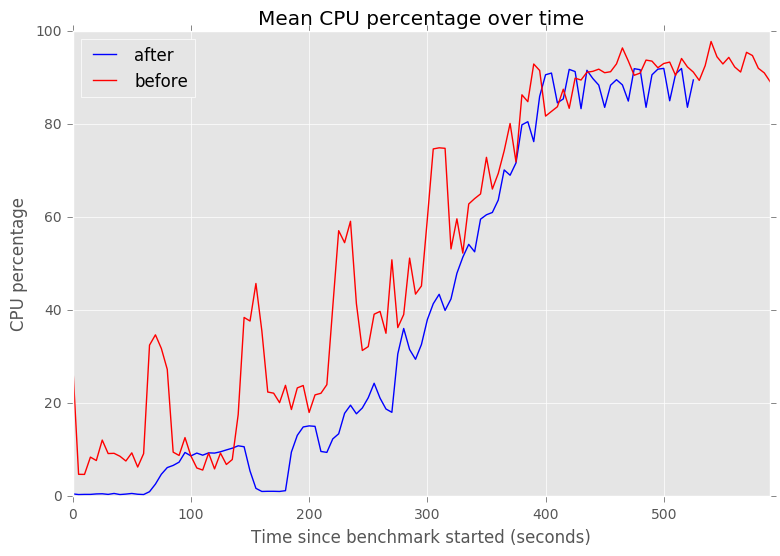

In [38]:
fig, ax = plt.subplots()
ax = cpuMeanData.plot(ax=ax, y='percentage', c='b')
if compareDatasets:
    ax = oldCpuMeanData.plot(ax=ax, y='percentage', c='r')
    ax.legend([newDataLabel, oldDataLabel])
else:
    ax.legend(['mean'])
ax.set_ylabel('CPU percentage')
ax.set_xlabel('Time since benchmark started (seconds)')
ax.set_title('Mean CPU percentage over time')
plt.show()

To avoid degradation of service, you should avoid keeping Gorouter running at max CPU utilization. Keep track of the time at which Gorouter reaches maximum CPU utilization in the plot above. The plots in the next sections will illustrate how to scale Gorouter to fit your service level agreements and maintain good performance of the Gorouters.

## Gorouter Throughput over Time

The following plot shows a summary of the throughput load over the duration of the test run, labeled in seconds since the benchmark test started.

Here are some key points to note when looking at this data:

  - There are many violent zigzags towards the end of the throughput test. This is mainly due to the high number of routes
    registered in the Gorouter. You'll even notice troughs of throughput, which represent the periodic registration of
    routes in Gorouter.
  - It's possible for the line to cut off before the end of the plot. This indicates that the performance test run
    finished at the cut off point.

You'll notice that the throughput plot ramps up along with the load level, and then plateaus at a certain point. This point should correspond with where the CPU plot plateaus.


In [39]:
def readThroughputData(filename):
    with open(filename) as f:
        data = f.read()
    # Get locations of start-time,response-time headers in file
    header_idxs = [m.start() for m in re.finditer('start-time,response-time', data)]
    header_idxs.append(len(data))
    prev = header_idxs[0]
    
    df = pd.DataFrame()
    # Read each section delimited by the csv headers
    for cur in header_idxs[1:]:
        dfSection = pd.read_csv(StringIO(data[prev:cur]), parse_dates=['start-time'])
        df = df.append(trimEdges(dfSection))
        prev = cur
    # Reset the index because it is a Frankenstein's monster of smaller indexes
    df = df.reset_index().drop('index', axis=1)
    return df
    
def trimEdges(data):
    indexes = data.set_index('start-time').resample('1S').aggregate(lambda x: 1).index
    testStartTime = indexes[1]
    testEndTime = indexes[-2]
    return data[(data['start-time'] >= testStartTime) & (data['start-time'] <= testEndTime)]
    
def processThroughputData(data):
    buckets = data.set_index('start-time')['response-time'].resample('1S')
    throughputData = buckets.aggregate({'throughput': lambda x: np.nan if x.count() == 0 else x.count()})
    throughputData = throughputData.reset_index()
    throughputData = throughputData.fillna(method='ffill')
    return buckets, throughputData
    
goData = readThroughputData('perfResults.csv')
throughputBuckets, throughputData = processThroughputData(goData)

if compareDatasets:
    oldGoData = readThroughputData('old_perfResults.csv')
    oldThroughputBuckets, oldThroughputData = processThroughputData(oldGoData)

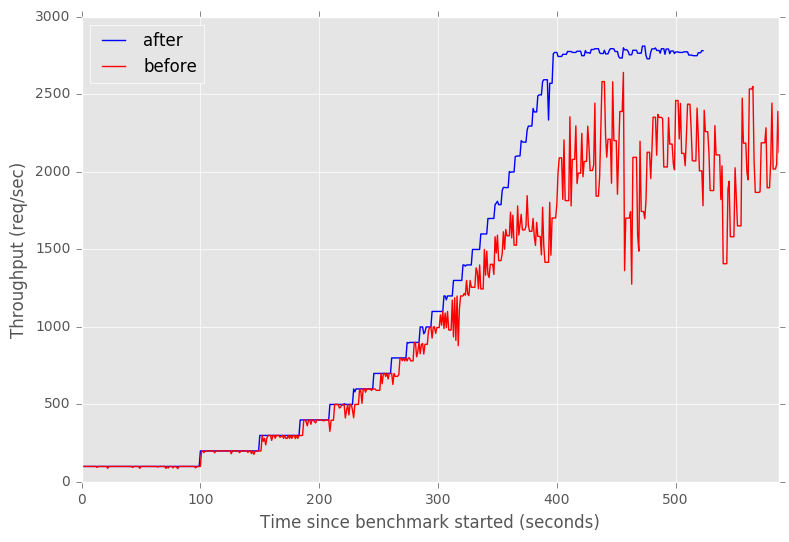

In [40]:
fix, ax = plt.subplots()
ax = throughputData.plot(ax=ax, y='throughput', c='b')
if compareDatasets:
    ax = oldThroughputData.plot(ax=ax, y='throughput', c='r')
    ax.legend([newDataLabel, oldDataLabel])
ax.set_ylabel('Throughput (req/sec)')
ax.set_xlabel('Time since benchmark started (seconds)')
plt.show()

The throughput level at which the plot plateaus is the absolute maximum throughput that each Gorouter VM will be able to handle.
To avoid degradation of service, you should scale up the number of Gorouter instances so that the required load level on each Gorouter does not exceed this maximum load level. To optimize for low latency, you would also need give each Gorouter some headroom in the amount of additional load over its supported load level by scaling up the number of instances of Gorouter before Gorouter reaches this maximum load level.

## Throughput Headroom Plot

This is a throughput vs latency plot that illustrates how to find Gorouter's supported load level in order to give each Gorouter enough headroom to handle additional load before it reaches the maximum load level.

To make use of this plot, first find the target average response time for each request as set by the service level agreements (SLAs) for your CloudFoundry installation.

Find the point in the blue line below where its y-value meets your SLAs and draw a line vertically below this point to figure out Gorouter's supported load level.

In [41]:
goData['throughput'] = throughputBuckets.transform(len).reset_index()['response-time']
goData.columns = ['start-time', 'latency', 'throughput']

if compareDatasets:
    oldGoData['throughput'] = oldThroughputBuckets.transform(len).reset_index()['response-time']
    oldGoData.columns = ['start-time', 'latency', 'throughput']

In [42]:
def generateFitLine(data):
    y, x = dmatrices('latency ~ throughput', data=data, return_type='dataframe')
    fit = sm.GLM(y, x, family=sm.families.InverseGaussian(sm.families.links.inverse_squared)).fit()

    domain = np.arange(data['throughput'].min(), data['throughput'].max())
    predictionInputs = np.ones((len(domain), 2))
    predictionInputs[:,1] = domain
    fitLine = fit.predict(predictionInputs)
    return domain, fitLine

domain, goFitLine = generateFitLine(goData)

if compareDatasets:
    oldDomain, oldGoFitLine = generateFitLine(oldGoData)

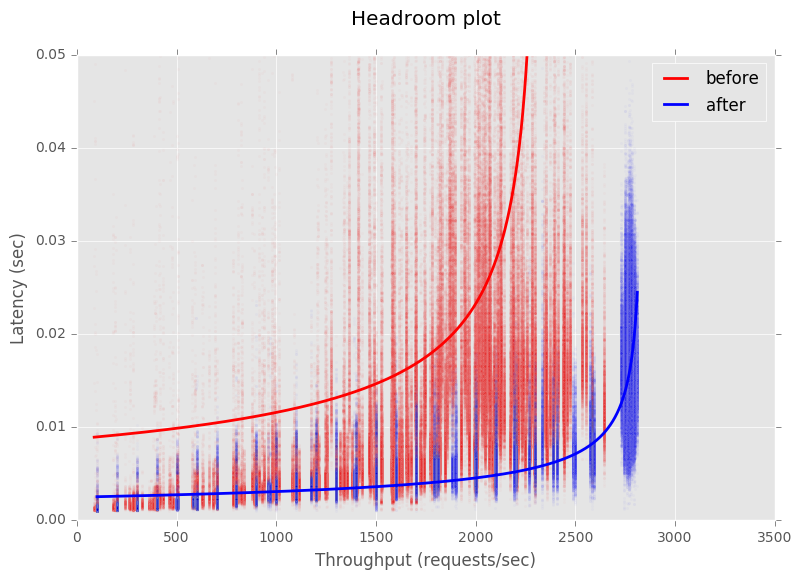

In [43]:
fig, ax = plt.subplots()

if compareDatasets:
    ax = oldGoData.plot(ax=ax, kind='scatter', x='throughput', y='latency', c='r', marker='.', alpha=0.02)
    ax.plot(oldDomain, oldGoFitLine, c='r', lw=2) # Plot the fit line

# Change the value of `c` to change the color. http://matplotlib.org/api/colors_api.html
ax = goData.plot(ax=ax, kind='scatter', x='throughput', y='latency', c='b', marker='.', alpha=0.02)
ax.plot(domain, goFitLine, c='b', lw=2) # Plot the fit line

if compareDatasets:
    ax.legend([oldDataLabel, newDataLabel])

# To update x & y axis range change the parameters in function set_(x/y)lim(lower_limit, uppper_limit) 
ax.set_ylim(0,0.05)
ax.set_xlim(0,3500)
plt.xlabel('Throughput (requests/sec)')
plt.ylabel('Latency (sec)')
plt.title('Headroom plot', y=1.05)
plt.show()

If you have a target maximum throughput in the SLAs for your Gorouter installation, divide that number by the supported load level and round up to the nearest whole number. This is the minimum amount of Gorouter VMs (`c3.large`) you will need to meet your SLAs.

For example, if you need to be able to process 10,000 requests per second with 20 milliseconds of average response time, and this point corresponds to 2,500 requests per second for Gorouter's supported load level, then you would need at least 4 Gorouter VMs to handle this amount of load without degradation of service.